# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon

Marie Guertin

# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(1234)

## Data Preprocessing

Acquire data, analyze it and clean it

In [ ]:
# 13 feature columns and 2 prediction columns
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# 1) IMPORT DATA
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)

# 2) CLEAN-UP
train_df_obj = train_df.select_dtypes(['object'])
test_df_obj = test_df.select_dtypes(['object'])

train_df[train_df_obj.columns] = train_df_obj.apply(lambda x: x.str.strip())
test_df[test_df_obj.columns] = test_df_obj.apply(lambda x: x.str.strip())


# 3) REMOVE USELESS FEATURES
# count number of zeros or nan values per column and drop columns with more than 75% of 0 or nan values
num_instances = train_df.shape[0]
useless_data_threshold = 0.75

for c in columns:
    useless_proportion = (train_df[c].isna().sum() + (train_df[c] == 0).sum()) / num_instances
    if useless_proportion > useless_data_threshold:
        train_df.drop(columns = c, inplace = True)
        test_df.drop(columns = c, inplace = True)

# 4) FEATURE ONE_HOT_ENCODING 

for cat in categorical_columns:    
    # concatenante one hot encoded dummies columns
    train_df, test_df = pd.concat([train_df, pd.get_dummies(train_df[cat], prefix = cat, prefix_sep = '_')], axis = 1), pd.concat([test_df, pd.get_dummies(train_df[cat], prefix = cat, prefix_sep = '_')], axis = 1)
    
    # drop old columns
    train_df, test_df = train_df.drop(columns = cat), test_df.drop(columns = cat)
    
# 5) MOVE PREDICTION COLUMN TO THE END

y_train, y_test = train_df.pop('salary'), test_df.pop('salary')
train_df, test_df = pd.concat([train_df, y_train],axis=1), pd.concat([test_df, y_test],axis=1)


# 6) NUMERIZE PREDICTION VARIABLE

# - '>50K': 1
# - '<=50K': 0
train_df['salary'] = train_df['salary'].apply(lambda x: 1 if (x == '>50K') else 0)
train_df

## Cross Validation

helper method to perform the splits for L-fold cross-validation

In [ ]:
def cross_validate_splits(n, n_folds=5):
    # get the number of data samples in each split
    splits = []
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        # get the validation indexes
        val_inds = list(range(f * n_val, (f+1) * n_val))
        
        # get the training indexes
        tr_inds = list()
        if f < n_folds - 1:
            tr_inds = list(range((f+1) * n_val, n))
        
        if f > 0:
            tr_inds = tr_inds + list(range(0, f * n_val))
        splits.append((tr_inds, val_inds))
    return splits

## Validation Metrics

In [ ]:
# define MSE loss function
loss = lambda y, y_pred: np.mean((y-y_pred)**2)

#define accuracy function
accuracy = lambda y, y_pred: np.sum(y == y_pred)/y.size

## KNN Cross-Validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# convert to numpy arrays
train, test = train_df.to_numpy(), test_df.to_numpy()

num_instances = train.shape[0]

x, y = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

# number of folds for L-fold cross-validation
L = 5

def knn_cross_validation(x, y, K_list, L):

    num_instances = x.shape[0]
        
    # l-fold cross validation splits
    n_folds_splits = cross_validate_splits(num_instances, n_folds=L)

    # K x L matrix
    err_val_matrix, acc_val_matrix = np.zeros((len(K_list),L)), np.zeros((len(K_list),L))
    err_train_matrix, acc_train_matrix = np.zeros((len(K_list),L)), np.zeros((len(K_list),L))

    for i, K in enumerate(K_list):
        model = KNeighborsClassifier(n_neighbors=K)
        for j, split in enumerate(n_folds_splits):
            # split into train set and validation set
            x_train, x_val = x[split[0], :], x[split[1], :]
            y_train, y_val = y[split[0]], y[split[1]]

            model.fit(x_train, y_train)

            y_pred_val = model.predict(x_val)
            y_pred_train = model.predict(x_train)
            
            err_val = loss(y_val, y_pred_val)
            acc_val = accuracy(y_val, y_pred_val)
            
            err_train = loss(y_train, y_pred_train)
            acc_train = accuracy(y_train, y_pred_train)

            err_val_matrix[i][j] = err_val
            acc_val_matrix[i][j] = acc_val
            
            err_train_matrix[i][j] = err_train
            acc_train_matrix[i][j] = acc_train

    return err_val_matrix, acc_val_matrix, err_train_matrix, acc_train_matrix

### Visualization

1. MSE vs Number of NN (K)
2. Accuracy vs Number of NN (K)

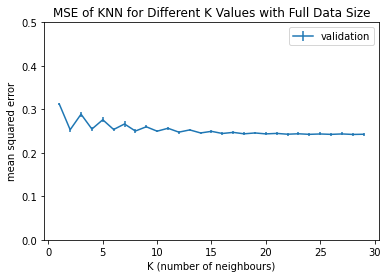

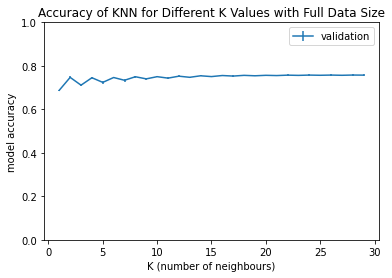

In [8]:
K_list = range(1,101)
err_matrix, acc_matrix = knn_cross_validation(x, y, K_list, L)

plt.title('MSE of KNN for Different K Values with Full Data Size')
plt.errorbar(K_list, np.mean(err_matrix, axis=1), np.std(err_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.ylim(0,0.5)
plt.show()

plt.title('Accuracy of KNN for Different K Values with Full Data Size')
plt.errorbar(K_list, np.mean(acc_matrix, axis=1), np.std(acc_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('model accuracy')
plt.ylim(0,1)
plt.show()

## Sample Growing Data

Test with different training data sizes

In [ ]:
sizes = [10, ]

inds = np.random.permutation(range(train.shape[0]))

for s in sizes:
    # K range list
    K_list = range(1,int((L-1)/L*(s+1)))
    
    # select s random samples from train dataset
    x_subset, y_subset = x[np.random.choice(inds,s, replace=False)], y[np.random.choice(inds,s, replace=False)]
    
    # apply cross validation to get validation and train error matrices 
    err_val_matrix, acc_val_matrix, err_train_matrix, acc_train_matrix = knn_cross_validation(x_subset, y_subset, K_list, L)
    
    plt.title('MSE of KNN for Different K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, np.mean(err_val_matrix, axis=1), np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.ylim(0,1)
    plt.show()

    plt.title('Accuracy of KNN for Different K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(acc_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, np.mean(acc_val_matrix, axis=1), np.std(acc_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('model accuracy')
    plt.ylim(0,1)
    plt.show()